In [1]:
import casadi as ca
import numpy as np
import pandas as pd
from pytope import Polytope
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


In [20]:
low_bound_control  = (-3, -3)
up_bound_control   = (3,   3)
U_SV_Poly = Polytope(lb = low_bound_control, ub = up_bound_control)
H = U_SV_Poly.A 
h = U_SV_Poly.b
nv = np.size(H, 0)
nu = np.size(H, 1)
N_Sam = 20

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 4
size of nu = 2


In [21]:
random_vals = np.random.uniform(-1, 1, size=(nu,N_Sam))
print(random_vals)
print(random_vals.shape)

[[-0.73961073  0.04364688 -0.97695026 -0.81478878  0.1752378  -0.59785362
   0.271784    0.44193614 -0.03321633  0.23111064  0.41645203  0.78042602
   0.42256499 -0.62754637  0.47010358  0.50862232 -0.99496311 -0.97070331
  -0.3472149  -0.26114792]
 [ 0.72423033  0.35766193 -0.44813955 -0.40798825  0.55846094  0.7519679
  -0.85258692 -0.31255738 -0.99587909  0.60787926 -0.86551032  0.7727045
   0.65750742  0.37724471  0.12567589  0.48682401 -0.64391834 -0.18389196
  -0.91934467  0.32703781]]
(2, 20)


In [22]:
data_id = "08"
background_filepath = f"./data/{data_id}_background.png"
recordingMeta_filepath = f"./data/{data_id}_recordingMeta.csv"
tracks_filepath = f"./data/{data_id}_tracks.csv"
tracksMeta_filepath = f"./data/{data_id}_tracksMeta.csv"

In [23]:
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == 17]
xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
random_vals = np.vstack((xAcc,yAcc))
print(random_vals.shape)
N_Sam = random_vals.shape[1]

(2, 1390)


In [24]:
def opti_LP(H):    
    opti = ca.Opti()

    rho = opti.variable()
    theta = opti.variable(nv,1)
    y = opti.variable(nu,1)

    samples = opti.parameter(nu, N_Sam)

    opti.minimize(rho + np.ones((1, nv))@theta)

    for i in range(N_Sam):
        opti.subject_to(H @ samples[:, i]-H @ y <= theta)

    opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
    opti.subject_to(opti.bounded(0, theta, 1))
    opti.subject_to(opti.bounded(0, rho, 1))
    opti.subject_to(theta <= rho@np.ones((nv,1)))

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples], [theta, y, rho]) 

In [7]:
f = opti_LP(H)
theta_hat, y_hat, rho_hat = f(random_vals)
print(theta_hat,y_hat,rho_hat)
U_hat_polytope = Polytope(H, theta_hat)+y_hat
print(U_hat_polytope.H)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[1.24657, 0.584295, 1, 1] [-1.02542, 0.420749] 1
[[-1.         -0.          2.27198852]
 [-0.         -1.          0.16354648]
 [ 1.          0.         -0.02541625]
 [ 0.          1.          1.42074902]]


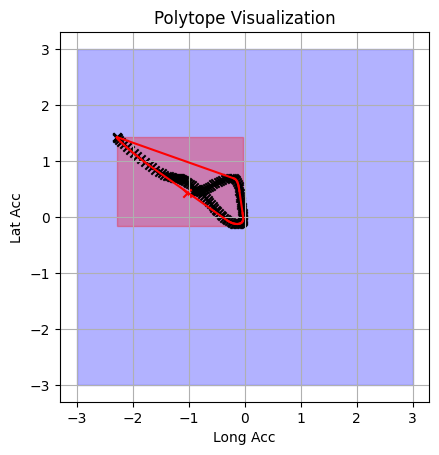

In [8]:
plt.figure()
#original polytope
U_SV_Poly.plot(color = 'b', alpha = 0.3)

#U_hat polytope
U_hat_polytope.plot(color = 'r', alpha = 0.3)

#sample points
plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')

#y
y_s_coodinate = np.array(y_hat)
plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

#convexhull
points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Polytope Visualization")
plt.xlabel("Long Acc")
plt.ylabel("Lat Acc")
plt.grid(True)
plt.show()

In [25]:
# Radius of the octagon
radius = 3

# Number of vertices
num_vertices = 10

# Generate the vertex coordinates
angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)  # Divide circle into 8 parts
x_coords = radius * np.cos(angles)
y_coords = radius * np.sin(angles)

# Combine x and y coordinates
vertices = np.column_stack((x_coords, y_coords))

In [26]:
U_SV_Poly = Polytope(vertices)
H = U_SV_Poly.A 
h = U_SV_Poly.b
nv = np.size(H, 0)
nu = np.size(H, 1)
for i in range(nv):
    H[i,:] /= h[i]
h = np.ones_like(h)

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 10
size of nu = 2


In [27]:
f = opti_LP(H)
theta_hat, y_hat, rho_hat = f(random_vals)
print(theta_hat,y_hat,rho_hat)
U_hat_polytope = Polytope(H, theta_hat)+y_hat

: 

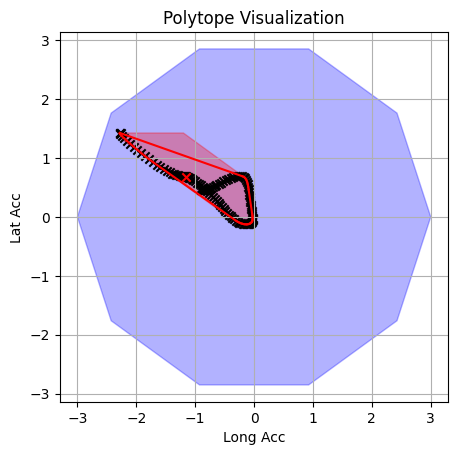

In [12]:
plt.figure()
#original polytope
U_SV_Poly.plot(color = 'b', alpha = 0.3)

#U_hat polytope
U_hat_polytope.plot(color = 'r', alpha = 0.3)

#sample points
plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')

#y
y_s_coodinate = np.array(y_hat)
plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

#convexhull
points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Polytope Visualization")
plt.xlabel("Long Acc")
plt.ylabel("Lat Acc")
plt.grid(True)
plt.show()

## Moving Horizon Method ##

In [13]:
mh_window_size = 50

In [14]:
def opti_LP_mh(H,mh_window_size):    
    opti = ca.Opti()

    rho = opti.variable()
    theta = opti.variable(nv,1)
    y = opti.variable(nu,1)

    samples = opti.parameter(nu, mh_window_size)

    opti.minimize(rho + np.ones((1, nv))@theta)

    for i in range(mh_window_size):
        opti.subject_to(H @ samples[:, i]-H @ y <= theta)

    opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
    opti.subject_to(opti.bounded(0, theta, 1))
    opti.subject_to(opti.bounded(0, rho, 1))
    opti.subject_to(theta <= rho@np.ones((nv,1)))

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples], [theta, y, rho]) 

In [15]:
U_SV_Poly = Polytope(vertices)
H = U_SV_Poly.A 
h = U_SV_Poly.b
nv = np.size(H, 0)
nu = np.size(H, 1)
for i in range(nv):
    H[i,:] /= h[i]
h = np.ones_like(h)

f_mh = opti_LP_mh(H,mh_window_size)

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 10
size of nu = 2


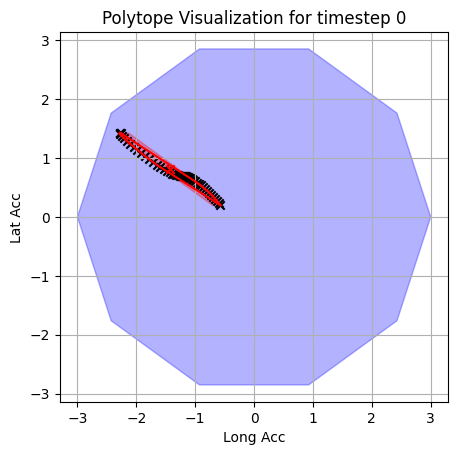

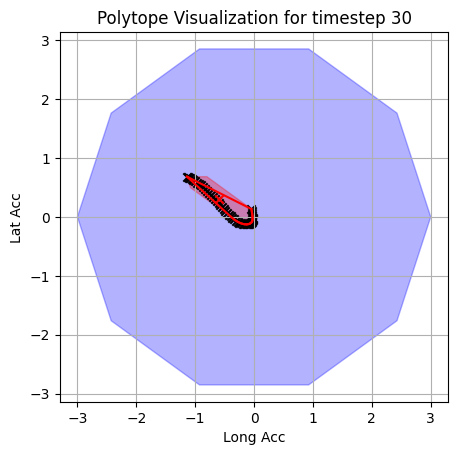

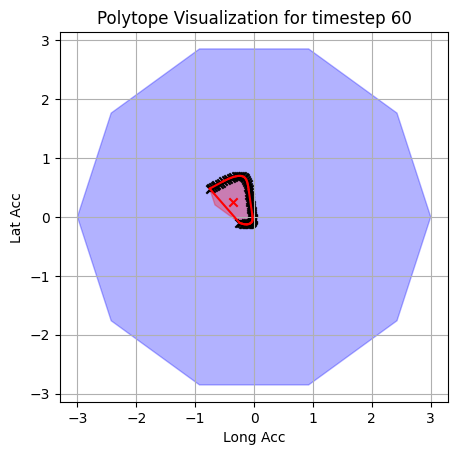

In [16]:
for i in range(N_Sam-mh_window_size):
    if(i%30 == 0):
        theta_hat, y_hat, rho_hat = f_mh(random_vals[:,i:i+mh_window_size])
        U_hat_polytope = Polytope(H, theta_hat)+y_hat
        
        #original polytope
        U_SV_Poly.plot(color = 'b', alpha = 0.3)

        #U_hat polytope
        U_hat_polytope.plot(color = 'r', alpha = 0.3)

        #sample points
        plt.scatter(random_vals[0,i:i+mh_window_size],random_vals[1,i:i+mh_window_size],marker='x',color = 'black')

        #y
        y_s_coodinate = np.array(y_hat)
        plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

        #convexhull
        points = random_vals[:,i:i+mh_window_size].T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

        plt.gca().set_aspect('equal', adjustable='box')
        plt.title(f"Polytope Visualization for timestep {i}")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()

## Online Recursive Method ##

In [17]:
def opti_LP_OR(H):    
    opti = ca.Opti()

    rho = opti.variable()
    theta = opti.variable(nv,1)
    y = opti.variable(nu,1)

    samples = opti.parameter(nu, 1)
    y_pre = opti.parameter(nu,1)
    theta_pre = opti.parameter(nv,1)

    opti.minimize(rho + np.ones((1, nv))@theta)

    opti.subject_to(H @ samples-H @ y <= theta)
    opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
    opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
    opti.subject_to(opti.bounded(0, theta, 1))
    opti.subject_to(opti.bounded(0, rho, 1))
    opti.subject_to(theta <= rho@np.ones((nv,1)))

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho]) 

In [18]:
U_SV_Poly = Polytope(vertices)
H = U_SV_Poly.A 
h = U_SV_Poly.b
for i in range(nv):
    H[i,:] /= h[i]
h = np.ones_like(h)

nv = np.size(H, 0)
nu = np.size(H, 1)

f_or = opti_LP_OR(H)

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 10
size of nu = 2


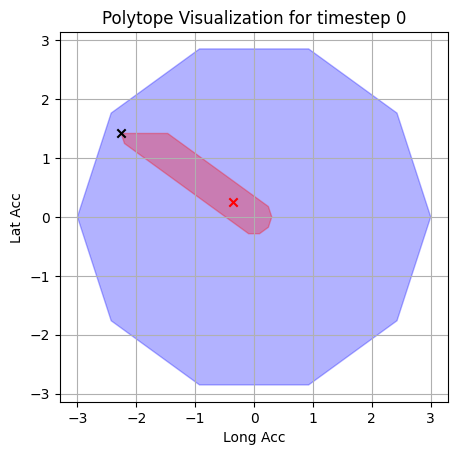

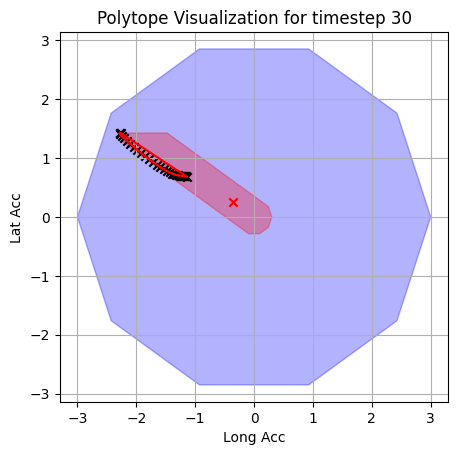

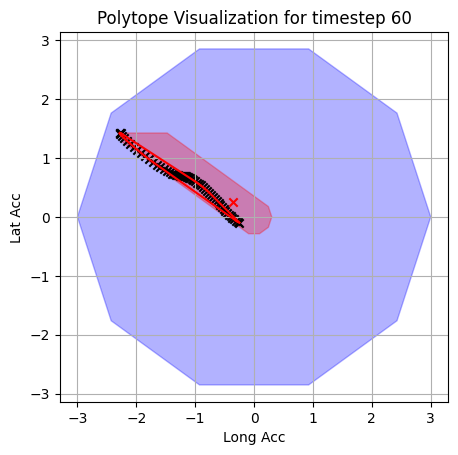

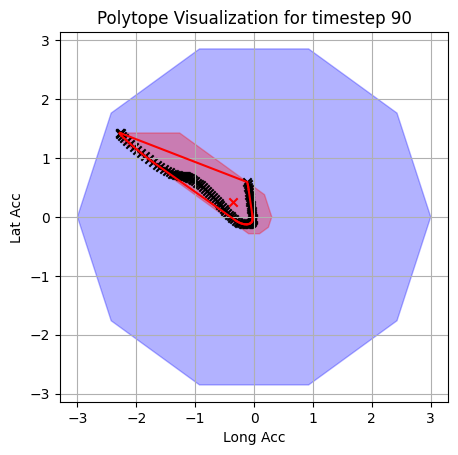

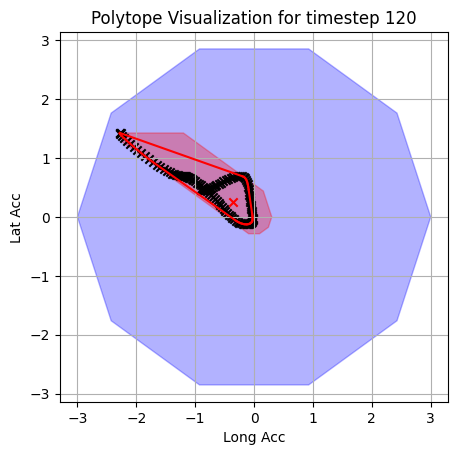

In [19]:
#initialization
theta_pre, y_pre, rho_pre = f_or(np.array([[0],[0]]),np.zeros((nu,1)),0.1*np.ones((nv,1)))

for i in range(N_Sam):
    theta_pre,y_pre,rho_pre = f_or(random_vals[:,i],y_pre,theta_pre)
    U_hat_polytope = Polytope(H, theta_pre)+y_pre

    if(i%30 == 0):
        #original polytope
        U_SV_Poly.plot(color = 'b', alpha = 0.3)

        #U_hat polytope
        U_hat_polytope.plot(color = 'r', alpha = 0.3)

        #sample points
        plt.scatter(random_vals[0,:i+1],random_vals[1,:i+1],marker='x',color = 'black')

        #y
        y_s_coodinate = np.array(y_hat)
        plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

        #convexhull
        if i > 1:
            points = random_vals[:,:i+1].T
            hull = ConvexHull(points)
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

        plt.gca().set_aspect('equal', adjustable='box')
        plt.title(f"Polytope Visualization for timestep {i}")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()
    